<a href="https://colab.research.google.com/github/Muhammedali26/Projects/blob/master/Synthetic-data-fraud-detection/main_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import numpy as np

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammedali26","key":"6ccab65682b53fdc72d4aeb902ae309d"}'}

In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d ealaxi/paysim1

 99% 176M/178M [00:07<00:00, 26.2MB/s]
100% 178M/178M [00:07<00:00, 25.8MB/s]


In [46]:
data = pd.read_csv("/content/paysim1.zip")

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction.

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [47]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [48]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [69]:
data_w_outliers = data

In [ ]:
data_w_outliers

# Missing value and outliers

In [ ]:
missing_values = data.isnull().sum()
print("Eksik Değerler:\n", missing_values)

# Yanlış veri veya aykırı değer kontrolü
outliers = data.describe(percentiles=[.25, .5, .75, .90, .95, .99]).transpose()
print("Aykırı Değerler:\n", outliers)

In [ ]:
z_scores = (data['amount'] - data['amount'].mean()) / data['amount'].std()

# Eşik değerini belirleme (örneğin, 3 standart sapma)
threshold = 3

# Eşik değeri üzerindeki aykırı değerleri filtreleme
outliers = data[abs(z_scores) > threshold]

# Aykırı değerleri çıkarılmış veri seti
cleaned_data = data[abs(z_scores) <= threshold]

# Aykırı değerleri ve temizlenmiş veri setini görüntüleme
print("Aykırı Değerler:\n", outliers)
print("Temizlenmiş Veri Seti:\n", cleaned_data)


# Feature Engineering with outliers

In [53]:
data_w_outliers['inactive_duration'] = data_w_outliers['step'].diff()  # Örneğin, hareketsiz süreyi hesaplayalım

# İhtiyaca göre daha fazla özellik mühendisliği yapabilirsiniz
data_w_outliers['transaction_ratio'] = data_w_outliers['amount'] / data_w_outliers['oldbalanceOrg']
data_w_outliers['balance_change'] = data_w_outliers['newbalanceOrig'] - data_w_outliers['oldbalanceOrg']
# ... diğer özellikler .

In [54]:
data_w_outliers

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,inactive_duration,transaction_ratio,balance_change
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,NaN,0.057834,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.0,0.087735,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.0,1.000000,-181.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.0,1.000000,-181.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.0,0.280795,-11668.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.0,1.000000,-339682.13
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0.0,1.000000,-6311409.28
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0.0,1.000000,-6311409.28
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.0,1.000000,-850002.52


In [55]:
data_w_outliers['date'] = pd.to_datetime(data_w_outliers['step'], unit='h')

In [56]:
data_w_outliers.set_index('date',inplace=True)

In [57]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding yöntemi ile "type" sütununu sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
data_w_outliers['type_encoded'] = label_encoder.fit_transform(data_w_outliers['type'])


In [58]:
# Hangi sayının hangi "type"ı temsil ettiğini öğrenme
type_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(type_mapping)

{0: 'CASH_IN', 1: 'CASH_OUT', 2: 'DEBIT', 3: 'PAYMENT', 4: 'TRANSFER'}


In [ ]:
data_w_outliers.drop(["type"],axis=1,inplace=True)

In [70]:
data_w_outliers.isna().sum()

step                 0
amount               0
nameOrig             0
oldbalanceOrg        0
newbalanceOrig       0
nameDest             0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
inactive_duration    0
transaction_ratio    0
balance_change       0
type_encoded         0
dtype: int64

In [71]:
data_w_outliers.dropna(how="any",inplace=True)

In [ ]:
data_w_outliers.head()

In [73]:
data_w_outliers.isna().sum()

step                 0
amount               0
nameOrig             0
oldbalanceOrg        0
newbalanceOrig       0
nameDest             0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
inactive_duration    0
transaction_ratio    0
balance_change       0
type_encoded         0
dtype: int64

In [74]:
data_w_outliers.drop(["nameDest","nameOrig"],axis=1,inplace=True)

In [75]:
data_w_outliers = data_w_outliers[np.isfinite(data_w_outliers).all(1)]

In [ ]:
"""X = data_w_outliers.loc[(data_w_outliers.type == 'TRANSFER') | (data_w_outliers.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)"""

# Feature Engineering without outliers

In [76]:
cleaned_data['inactive_duration'] = cleaned_data['step'].diff()  # Örneğin, hareketsiz süreyi hesaplayalım

# İhtiyaca göre daha fazla özellik mühendisliği yapabilirsiniz
cleaned_data['transaction_ratio'] = cleaned_data['amount'] / cleaned_data['oldbalanceOrg']
cleaned_data['balance_change'] = cleaned_data['newbalanceOrig'] - cleaned_data['oldbalanceOrg']
# ... diğer özellikler .

In [77]:
cleaned_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,inactive_duration,transaction_ratio,balance_change
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,NaN,0.057834,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.0,0.087735,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.0,1.000000,-181.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.0,1.000000,-181.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.0,0.280795,-11668.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.00,C1240760502,503464.50,1762283.33,1,0,0.0,1.000000,-1258818.82
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,0,0.0,1.000000,-339682.13
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.0,1.000000,-339682.13
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.0,1.000000,-850002.52


In [78]:
cleaned_data['date'] = pd.to_datetime(cleaned_data['step'], unit='h')

In [79]:
cleaned_data.set_index('date',inplace=True)

In [80]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding yöntemi ile "type" sütununu sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
cleaned_data['type_encoded'] = label_encoder.fit_transform(cleaned_data['type'])


In [81]:
# Hangi sayının hangi "type"ı temsil ettiğini öğrenme
type_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(type_mapping)

{0: 'CASH_IN', 1: 'CASH_OUT', 2: 'DEBIT', 3: 'PAYMENT', 4: 'TRANSFER'}


In [82]:
cleaned_data.drop(["type"],axis=1,inplace=True)

In [83]:
cleaned_data.isna().sum()

step                  0
amount                0
nameOrig              0
oldbalanceOrg         0
newbalanceOrig        0
nameDest              0
oldbalanceDest        0
newbalanceDest        0
isFraud               0
isFlaggedFraud        0
inactive_duration     1
transaction_ratio    16
balance_change        0
type_encoded          0
dtype: int64

In [84]:
cleaned_data.dropna(how="any",inplace=True)

In [85]:
cleaned_data.isna().sum()

step                 0
amount               0
nameOrig             0
oldbalanceOrg        0
newbalanceOrig       0
nameDest             0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
inactive_duration    0
transaction_ratio    0
balance_change       0
type_encoded         0
dtype: int64

In [86]:
cleaned_data.drop(["nameDest","nameOrig"],axis=1,inplace=True)

In [87]:
cleaned_data = cleaned_data[np.isfinite(cleaned_data).all(1)]

# Data analysis with outliers

In [ ]:
summary_stats = data_w_outliers.describe()
print("Veri Setinin İstatistiksel Özeti:\n", summary_stats)

In [89]:
# "isFraud" değişkenine göre sahtekarlık ve normal işlem sayılarını görüntüleme
fraud_counts = data_w_outliers['isFraud'].value_counts()
print("\nSahtekarlık ve Normal İşlem Sayıları:\n", fraud_counts)


Sahtekarlık ve Normal İşlem Sayıları:
 0    4251998
1       8172
Name: isFraud, dtype: int64


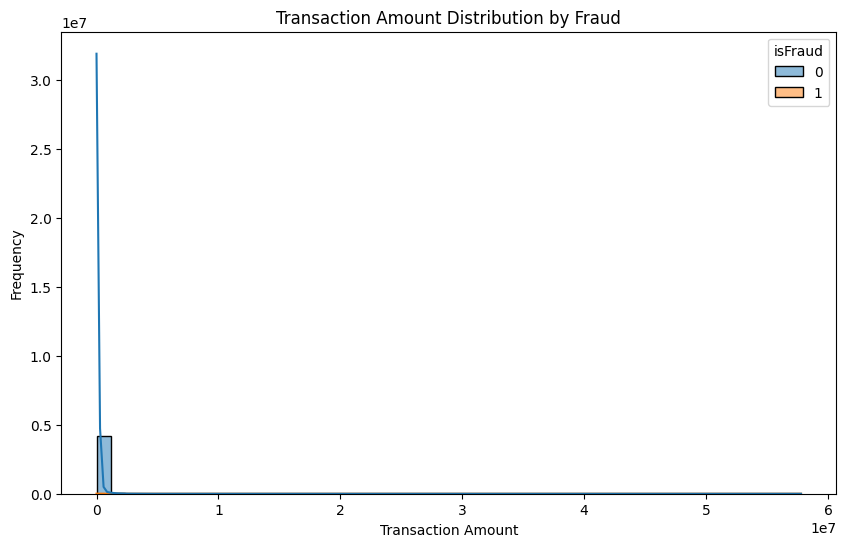

In [90]:
# Histogram grafiği ile "amount" özelliğinin dağılımını görselleştirme
plt.figure(figsize=(10, 6))
sns.histplot(data=data_w_outliers, x='amount', hue='isFraud', bins=50, kde=True)
plt.title("Transaction Amount Distribution by Fraud")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

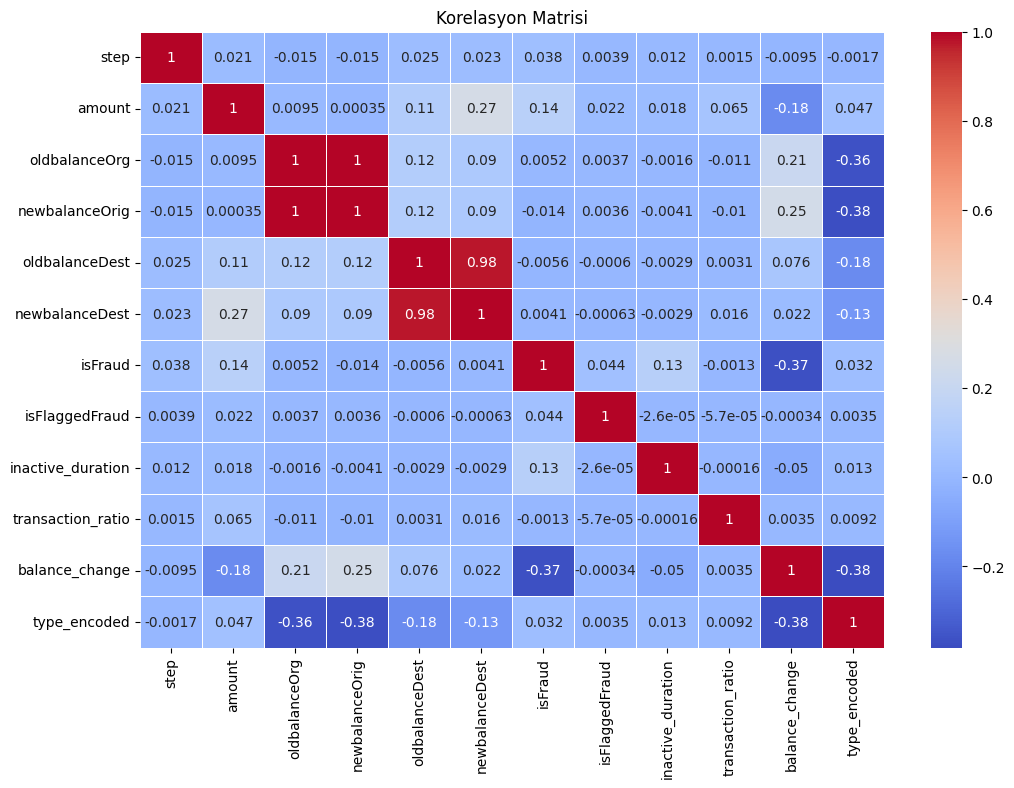

In [92]:
correlation_matrix = data_w_outliers.corr()

# Korelasyon matrisini görselleştirme
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()

##### Sahtekarlık işlemlerini zaman serisi olarak görselleştirme

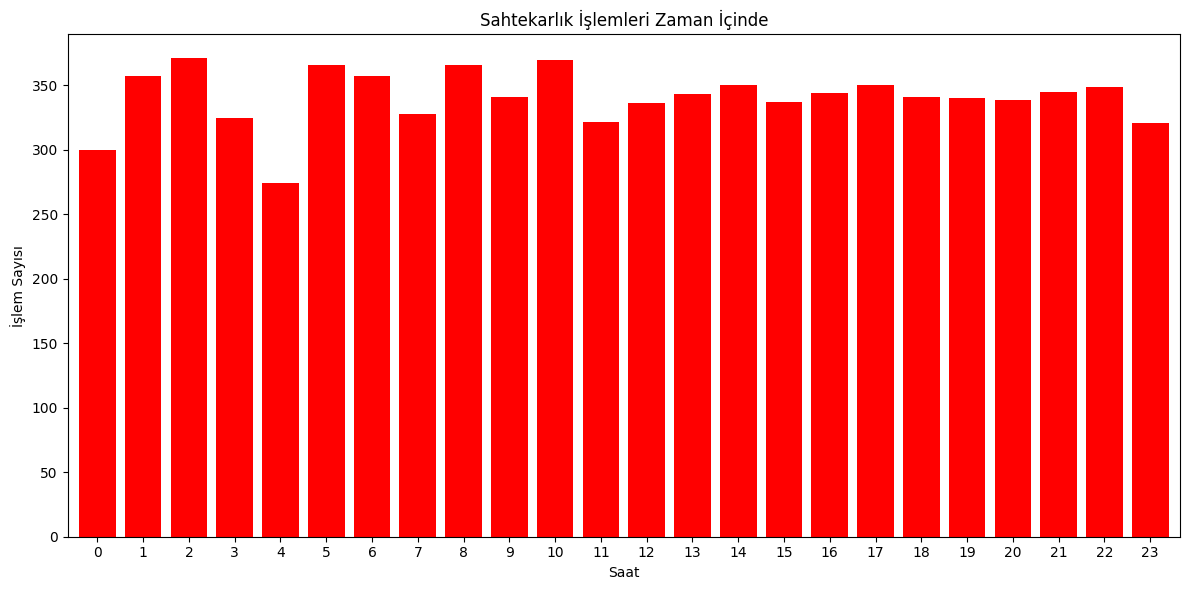

In [93]:


# Sahtekarlık işlemlerini belirli bir zaman diliminde toplayarak gruplama
fraud_data = data_w_outliers[data_w_outliers['isFraud'] == 1]
fraud_per_hour = fraud_data.groupby(fraud_data.index.hour).size()

# Zaman serisi grafiği
plt.figure(figsize=(12, 6))
fraud_per_hour.plot(kind='bar', color='r', width=0.8)
plt.title("Sahtekarlık İşlemleri Zaman İçinde")
plt.xlabel("Saat")
plt.ylabel("İşlem Sayısı")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



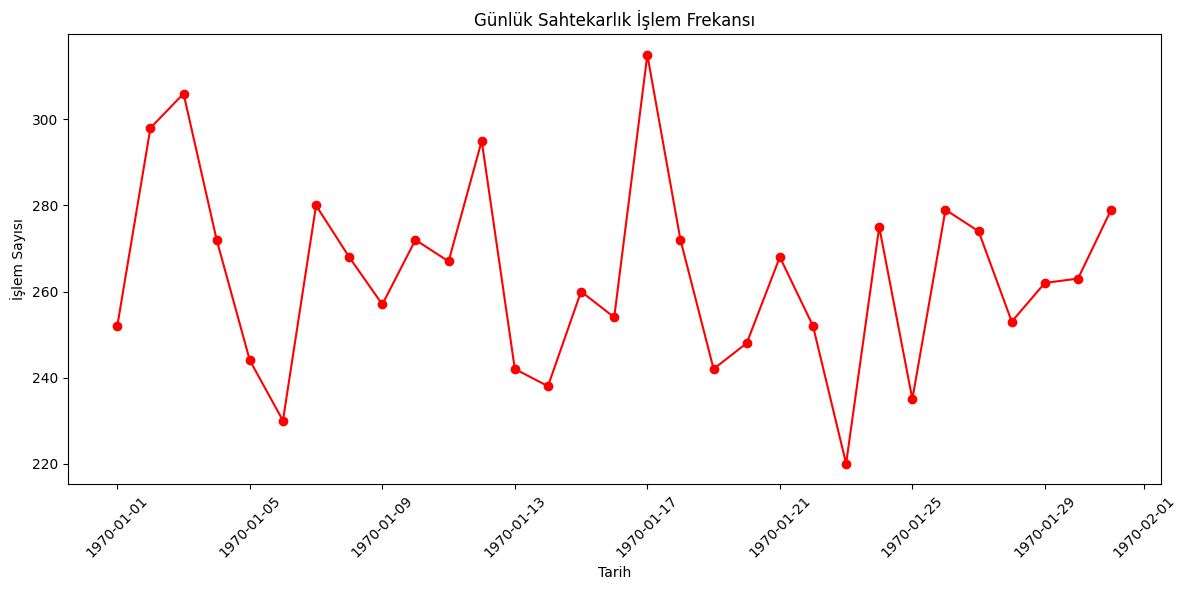

In [94]:

# Sahtekarlık işlemlerini günlük bazda toplayarak gruplama
fraud_per_day = fraud_data.groupby(fraud_data.index.date).size()

# Zaman serisi grafiği
plt.figure(figsize=(12, 6))
fraud_per_day.plot(kind='line', marker='o', color='r')
plt.title("Günlük Sahtekarlık İşlem Frekansı")
plt.xlabel("Tarih")
plt.ylabel("İşlem Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [101]:
data_w_outliers.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,inactive_duration,transaction_ratio,balance_change,type_encoded
date,,,,,,,,,,,,
1970-01-01 01:00:00,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,0.087735,-1864.28,3
1970-01-01 01:00:00,1,181.00,181.0,0.00,0.0,0.0,1,0,0.0,1.000000,-181.00,4
1970-01-01 01:00:00,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.0,1.000000,-181.00,1
1970-01-01 01:00:00,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,0.280795,-11668.14,3
1970-01-01 01:00:00,1,7817.71,53860.0,46042.29,0.0,0.0,0,0,0.0,0.145149,-7817.71,3


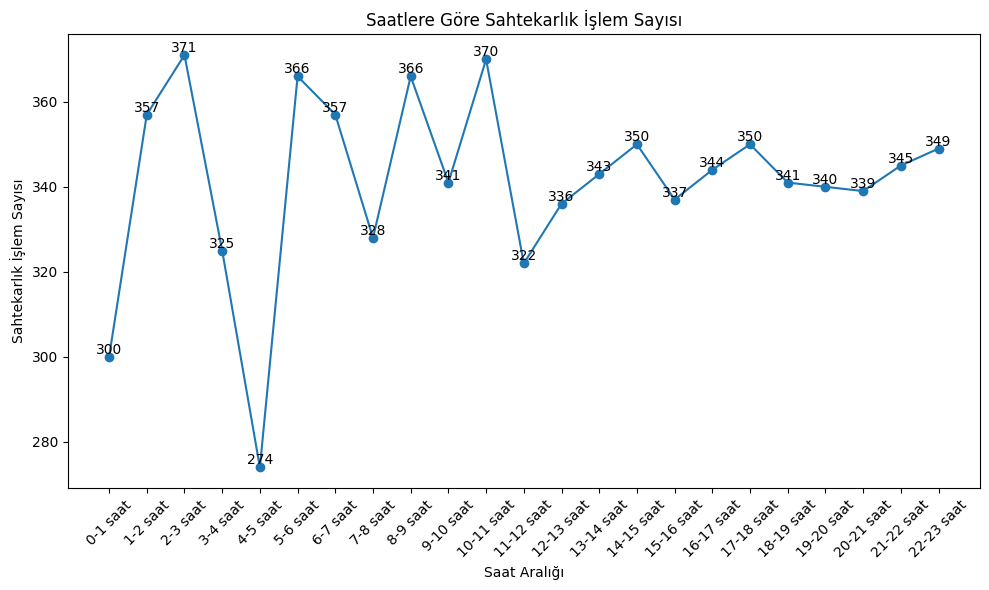

In [102]:

# Saatlik bazda sahtekarlık işlem sayısı analizi
hourly_fraud_data = data_w_outliers.groupby('date')['isFraud'].sum().reset_index()

# step sütununu saate çevirme
hourly_fraud_data['hour'] = pd.to_datetime(hourly_fraud_data['date'], unit='h').dt.hour

# Belirli saat aralıklarına göre sahtekarlık işlem sayısını hesaplama
hourly_bins = list(range(0, 24))  # 0-23 saat aralıkları
fraud_count_by_hour = []

for i in range(len(hourly_bins) - 1):
    lower_hour = hourly_bins[i]
    upper_hour = hourly_bins[i + 1]
    filtered_data = hourly_fraud_data[(hourly_fraud_data['hour'] >= lower_hour) & (hourly_fraud_data['hour'] < upper_hour)]
    fraud_transactions_in_hour = filtered_data['isFraud'].sum()
    fraud_count_by_hour.append(fraud_transactions_in_hour)

# Sahtekarlık işlem sayısını saatlere göre çizdirme
plt.figure(figsize=(10, 6))
plt.plot(range(len(hourly_bins) - 1), fraud_count_by_hour, marker='o')
plt.title("Saatlere Göre Sahtekarlık İşlem Sayısı")
plt.xlabel("Saat Aralığı")
plt.ylabel("Sahtekarlık İşlem Sayısı")
plt.xticks(range(len(hourly_bins) - 1), [f"{hourly_bins[i]}-{hourly_bins[i+1]} saat" for i in range(len(hourly_bins) - 1)], rotation=45)

# Noktaların tam olarak kaçı ifade ettiğini gösteren etiketleri ekleme
for i, count in enumerate(fraud_count_by_hour):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [103]:
hourly_fraud_data["isFraud"].sum()

8172

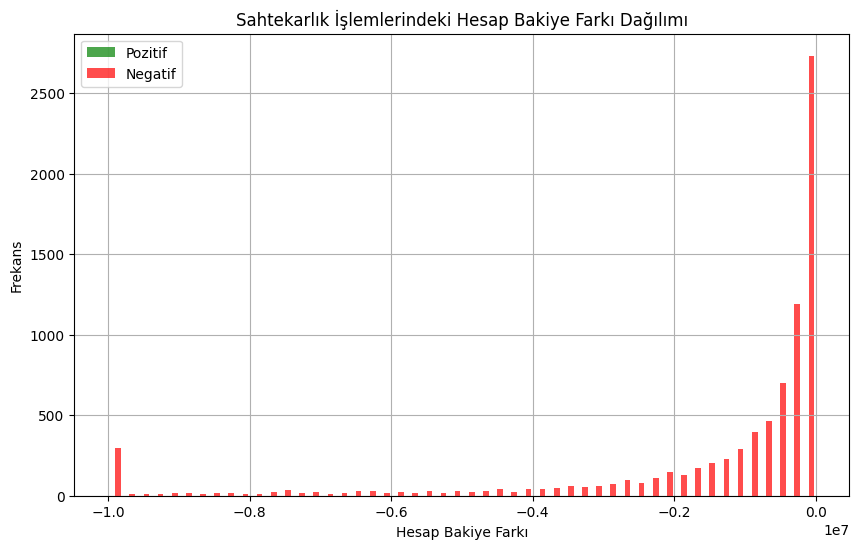

In [105]:
# Sahtekarlık işlemlerini içeren veriyi seçme
fraud_data = data_w_outliers[data_w_outliers['isFraud'] == 1]

# İşlem öncesi ve sonrası hesap bakiye farkını hesaplama
fraud_data['balance_diff'] = fraud_data['newbalanceOrig'] - fraud_data['oldbalanceOrg']

# Pozitif ve negatif bakiye farklarını ayırma
positive_balance_diff = fraud_data[fraud_data['balance_diff'] > 0]['balance_diff']
negative_balance_diff = fraud_data[fraud_data['balance_diff'] <= 0]['balance_diff']

# Histogram grafiğini çizdirme
plt.figure(figsize=(10, 6))
plt.hist([positive_balance_diff, negative_balance_diff], bins=50, color=['green', 'red'], alpha=0.7, label=['Pozitif', 'Negatif'])
plt.title("Sahtekarlık İşlemlerindeki Hesap Bakiye Farkı Dağılımı")
plt.xlabel("Hesap Bakiye Farkı")
plt.ylabel("Frekans")
plt.legend()
plt.grid(True)
plt.show()


Elimizdeki veride sadece dolandırılan hesapların bilgileri var bu yüzden de çıkan sonuçlar daima eksi değerde çıkıyor

Risk Dağılımı: Daha düşük meblağlarla dolandırıcılık yapılması, sahtekarların daha düşük riskli işlemleri tercih ettiğini gösterebilir. Bu durumda, sahtekarlar daha büyük işlemler yerine daha küçük işlemleri tercih ediyor olabilirler.

1. Daha Az Dikkat Çekme: Düşük meblağlarla yapılan dolandırıcılık işlemleri, genellikle finansal kurumların ve algoritmaların dikkatini çekmeyebilir. Bu nedenle sahtekarlar, daha düşük meblağlarla daha fazla işlem yaparak denetimden kaçmayı amaçlayabilirler.

2. Daha Fazla İşlem Sayısı: Daha düşük meblağlarla yapılan dolandırıcılık işlemleri, toplam işlem sayısını artırabilir. Bu durum, sahtekarların daha küçük miktarlarda işlem yaparak fark edilmemeye çalıştığını gösterebilir.

3. Birleşik Sahtekarlık Stratejileri: Sahtekarlar, düşük meblağlarla küçük işlemler yaparak hesap bakiyelerini etkilemeden sistemde daha uzun süre aktif kalabilirler. Bu, daha büyük meblağlarda yapılan dolandırıcılığa göre daha sinsi bir strateji olabilir.

Bu sonuçlar arasında sebep-sonuç ilişkilerini anlamak ve daha geniş bir perspektif kazanmak önemlidir. Daha fazla analiz ve veri üzerinde çalışarak, daha kesin sonuçlara ulaşabilir ve sahtekarlık işlemlerinin davranışsal örüntülerini daha iyi anlayabilirsiniz.

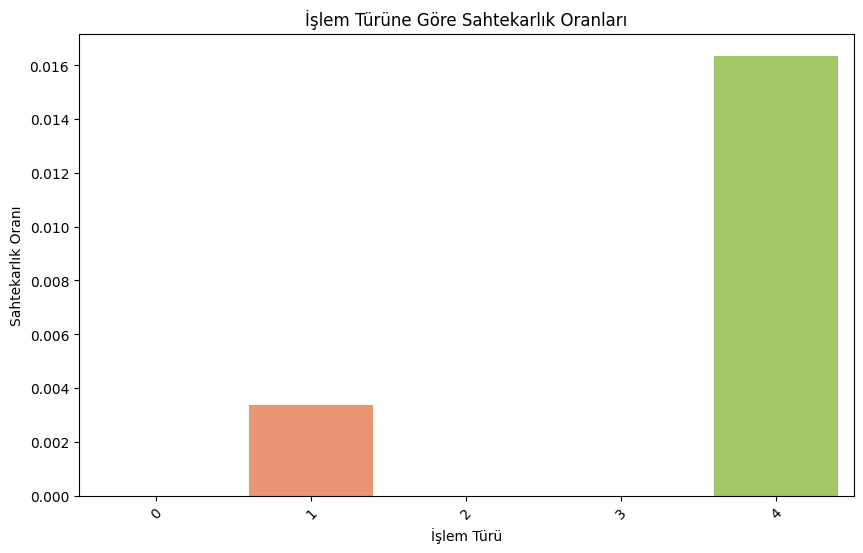

In [108]:
# İşlem türüne göre sahtekarlık oranlarını hesaplayın
fraud_by_type = data_w_outliers.groupby('type_encoded')['isFraud'].mean().reset_index()

# Grafik çizin
plt.figure(figsize=(10, 6))
sns.barplot(x='type_encoded', y='isFraud', data=fraud_by_type, palette='Set2')
plt.title("İşlem Türüne Göre Sahtekarlık Oranları")
plt.xlabel("İşlem Türü")
plt.ylabel("Sahtekarlık Oranı")
plt.xticks(rotation=45)
plt.show()

In [109]:
print(type_mapping)

{0: 'CASH_IN', 1: 'CASH_OUT', 2: 'DEBIT', 3: 'PAYMENT', 4: 'TRANSFER'}


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler

# Bağımsız değişkenleri (X) seçin
X = data_w_outliers.drop(['isFraud'], axis=1)

# Min-Max ölçeklendirme işlemi


# Normalized veriyi kullanarak model oluşturabilirsiniz

# (X_scaled ile devam edebilirsiniz)
# Bağımsız değişkenler (X) ve hedef değişken (y) belirleyin

y = data_w_outliers['isFraud']


In [112]:
# Eğitim ve test verisi olarak ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

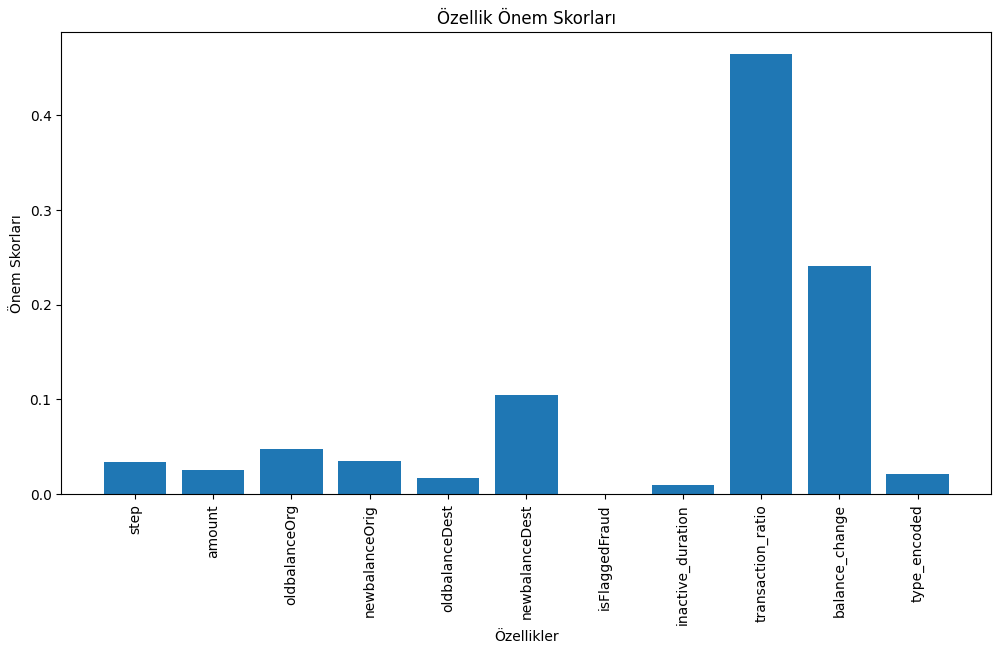

In [113]:

# Random Forest modelini oluşturun
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Özellik önem skorlarını alın
feature_importances = model.feature_importances_

# Özellik önem skorlarını görselleştirin
plt.figure(figsize=(12, 6))
plt.bar(X.columns, feature_importances)
plt.xticks(rotation=90)
plt.title("Özellik Önem Skorları")
plt.xlabel("Özellikler")
plt.ylabel("Önem Skorları")
plt.show()